In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudulent-transactions-data/Fraud.csv


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from keras.layers import Input, Dense
from keras.models import Model

In [43]:
df = pd.read_csv("/kaggle/input/fraudulent-transactions-data/Fraud.csv")

In [44]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [46]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


**Handling Missing Data**

In [47]:
# Filling missing values for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Optionally, drop rows where categorical data is missing (e.g., nameOrig or nameDest)
df.dropna(subset=['nameOrig', 'nameDest'], inplace=True)


**Missing values per column**

In [48]:
# Calculate the number of missing values in each column
missing_values_per_column = df.isnull().sum()

# Display the columns with their corresponding count of missing values
print(missing_values_per_column)


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


**Feature Scaling** -- We'll normalize the numerical features to ensure they contribute equally to the model.

In [49]:
# List of numerical columns to scale (excluding categorical or binary variables)
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Apply StandardScaler only to the selected numerical columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Now the DataFrame is ready for further analysis or modeling


In [50]:
# Check the mean and standard deviation of the scaled numerical columns
scaled_means = df[numerical_cols].mean()
scaled_stds = df[numerical_cols].std()

print("Means of scaled features:\n", scaled_means)
print("\nStandard deviations of scaled features:\n", scaled_stds)


Means of scaled features:
 amount           -4.946736e-17
oldbalanceOrg    -1.779646e-17
newbalanceOrig    6.590049e-16
oldbalanceDest    1.498762e-16
newbalanceDest   -1.340452e-16
dtype: float64

Standard deviations of scaled features:
 amount            1.0
oldbalanceOrg     1.0
newbalanceOrig    1.0
oldbalanceDest    1.0
newbalanceDest    1.0
dtype: float64


**Encoding** -- type column

In [51]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['type'])

df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = df[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)

# Display the DataFrame to check the changes
print(df.head())


   step    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0   1.0 -0.281560  C1231006815      -0.229810       -0.237622  M1979787155   
1   1.0 -0.294767  C1666544295      -0.281359       -0.285812  M2044282225   
2   1.0 -0.297555  C1305486145      -0.288654       -0.292442   C553264065   
3   1.0 -0.297555   C840083671      -0.288654       -0.292442    C38997010   
4   1.0 -0.278532  C2048537720      -0.274329       -0.282221  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  type_CASH_IN  \
0       -0.323814       -0.333411      0.0             0.0             0   
1       -0.323814       -0.333411      0.0             0.0             0   
2       -0.323814       -0.333411      1.0             0.0             0   
3       -0.317582       -0.333411      1.0             0.0             0   
4       -0.323814       -0.333411      0.0             0.0             0   

   type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0             

**Understand Distribution** -- We’ll start by analyzing the distribution of the features and the target variable (isFraud).

Distribution of the Target Variable

In [52]:
print(df['isFraud'].unique())

[0. 1.]


**Distribution of isFraud**

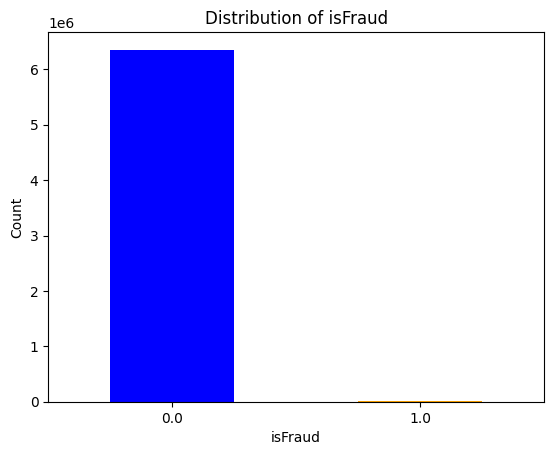

In [53]:
# Plotting the distribution of the 'isFraud' column
df['isFraud'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of isFraud')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


0 represents a legitimate (non-fraudulent) transaction

1 represents a fraudulent transaction

**Distribution of isFlaggedFraud**

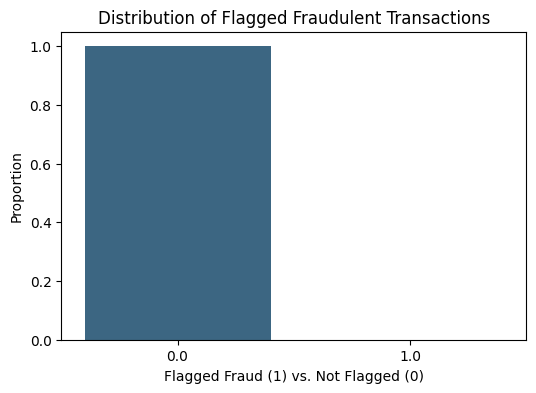

In [54]:
# Distribution of flagged fraud transactions
flagged_fraud_distribution = df['isFlaggedFraud'].value_counts(normalize=True)

# Plotting the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=flagged_fraud_distribution.index, y=flagged_fraud_distribution.values, palette='viridis')
plt.title('Distribution of Flagged Fraudulent Transactions')
plt.xlabel('Flagged Fraud (1) vs. Not Flagged (0)')
plt.ylabel('Proportion')
plt.show()


**Analyze the Relationship Between isFraud and isFlaggedFraud**

isFlaggedFraud      0.0  1.0
isFraud                     
0.0             6354407    0
1.0                8197   16


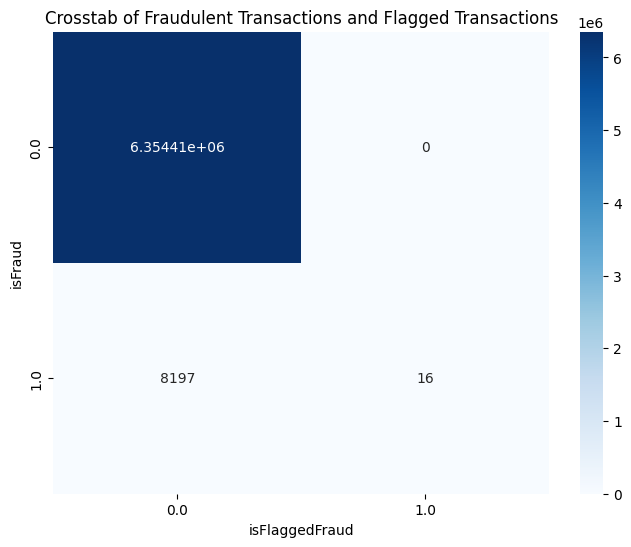

In [55]:
# Crosstab to analyze the relationship between isFraud and isFlaggedFraud
fraud_vs_flagged = pd.crosstab(df['isFraud'], df['isFlaggedFraud'])

# Display the crosstab
print(fraud_vs_flagged)

# Visualize the crosstab with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fraud_vs_flagged, annot=True, cmap='Blues', fmt='g')
plt.title('Crosstab of Fraudulent Transactions and Flagged Transactions')
plt.xlabel('isFlaggedFraud')
plt.ylabel('isFraud')
plt.show()


**Visualize Key Features in Relation to Fraud and Flagged Fraud**

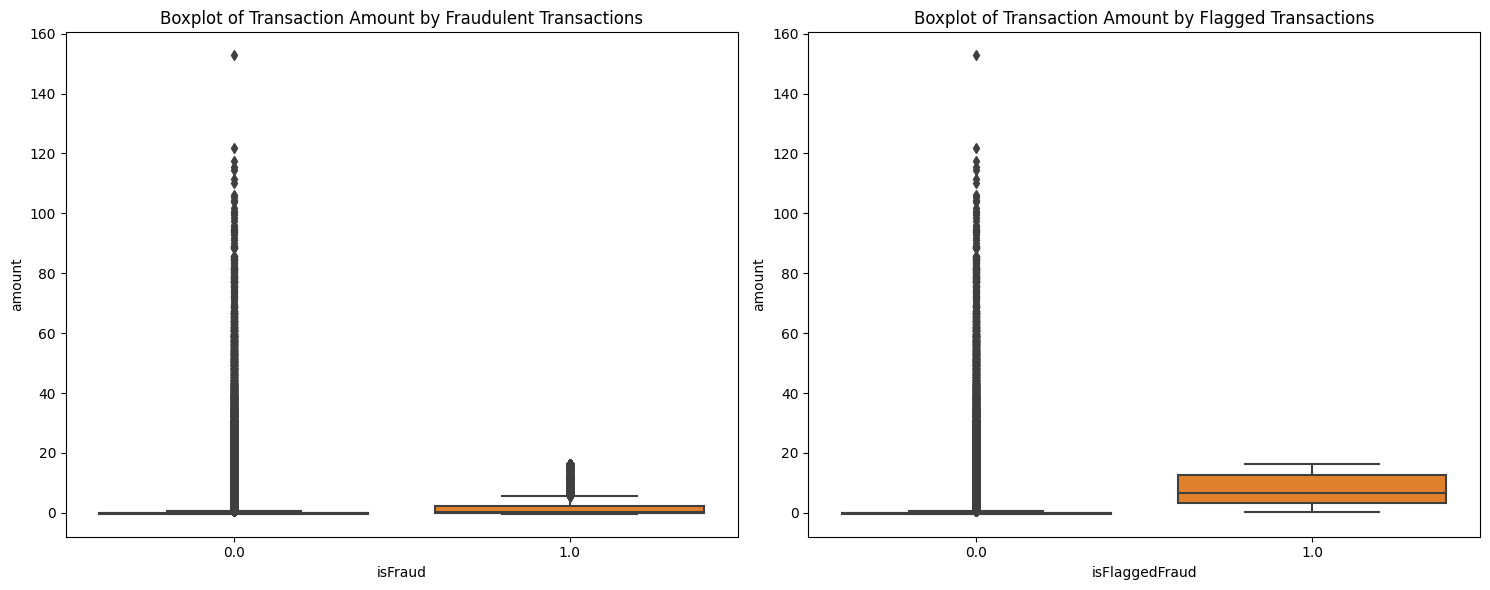

In [56]:
plt.figure(figsize=(15, 6))

# Box plot of amount vs. isFraud
plt.subplot(1, 2, 1)
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Boxplot of Transaction Amount by Fraudulent Transactions')

# Box plot of amount vs. isFlaggedFraud
plt.subplot(1, 2, 2)
sns.boxplot(x='isFlaggedFraud', y='amount', data=df)
plt.title('Boxplot of Transaction Amount by Flagged Transactions')

plt.tight_layout()
plt.show()


**Scatter Plot of amount vs. oldbalanceOrg Colored by isFraud**

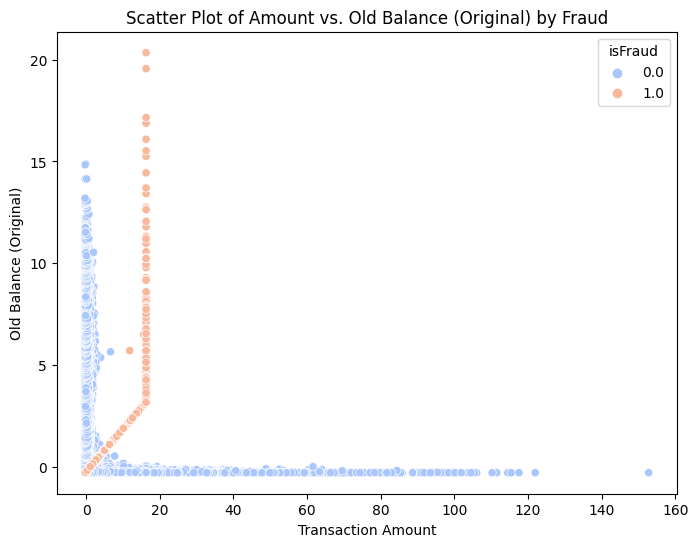

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='amount', y='oldbalanceOrg', hue='isFraud', data=df, palette='coolwarm')
plt.title('Scatter Plot of Amount vs. Old Balance (Original) by Fraud')
plt.xlabel('Transaction Amount')
plt.ylabel('Old Balance (Original)')
plt.show()


Scatter Plot of Transaction Amount vs. Old Balance (Original) by Fraud
The scatter plot visualizes the relationship between the transaction amount (x-axis) and the old balance (y-axis), with different colors representing whether the transaction is fraudulent or not (isFraud).

Key Observations:
Axes Interpretation:

Transaction Amount (x-axis): This represents the amount involved in the transaction. The range shown extends up to approximately 160.
Old Balance (Original) (y-axis): This represents the balance before the transaction took place. The range extends up to approximately 20.
Color Coding:

Blue Dots (isFraud = 0.0): These dots represent non-fraudulent transactions.
Orange Dots (isFraud = 1.0): These dots represent fraudulent transactions.
Pattern Analysis:

Non-Fraudulent Transactions (Blue Dots):

A large concentration of blue dots appears along the x-axis (transaction amount close to zero) and the y-axis (old balance close to zero). This indicates that most non-fraudulent transactions tend to have either small transaction amounts or small initial balances.
There is a significant spread of blue dots across the lower half of the plot, especially along the y-axis, suggesting that non-fraudulent transactions occur across a wide range of old balances.
Fraudulent Transactions (Orange Dots):

The orange dots form a distinct pattern, with most of them clustering near the lower left corner of the plot, where both the transaction amount and the old balance are close to zero.
A diagonal line of orange dots can be observed, starting from where both the transaction amount and old balance are near zero and moving upward as both values increase. This suggests that in fraudulent transactions, the transaction amount and old balance often correlate, possibly indicating an attempt to move amounts that match the available balance to avoid detection.
Insights:

The clustering of fraudulent transactions near the origin (lower transaction amounts and lower old balances) might indicate that fraudsters are more cautious, attempting to perform small transactions that might not raise immediate suspicion.
The diagonal line of fraudulent transactions may suggest a strategy where the fraudulent amount is closely matched to the available balance to minimize the chances of detection.
Potential Actions:

This pattern can help in fine-tuning anomaly detection models like Isolation Forests, where the correlation between transaction amount and old balance can be an important feature in detecting fraud.
The insights from this plot could also inform the design of rule-based systems to flag transactions where the amount closely matches the old balance, especially when both values are low.
This detailed interpretation of the scatter plot highlights the importance of visualizing and analyzing data distributions to understand patterns in fraudulent activities, which can then be used to improve fraud detection systems.

**Correlation Analysis** -- Check correlations between features to understand relationships and reduce multicollinearity.

                  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
amount          1.000000      -0.002762       -0.007861        0.294137   
oldbalanceOrg  -0.002762       1.000000        0.998803        0.066243   
newbalanceOrig -0.007861       0.998803        1.000000        0.067812   
oldbalanceDest  0.294137       0.066243        0.067812        1.000000   
newbalanceDest  0.459304       0.042029        0.041837        0.976569   
isFraud         0.076688       0.010154       -0.008148       -0.005885   

                newbalanceDest   isFraud  
amount                0.459304  0.076688  
oldbalanceOrg         0.042029  0.010154  
newbalanceOrig        0.041837 -0.008148  
oldbalanceDest        0.976569 -0.005885  
newbalanceDest        1.000000  0.000535  
isFraud               0.000535  1.000000  


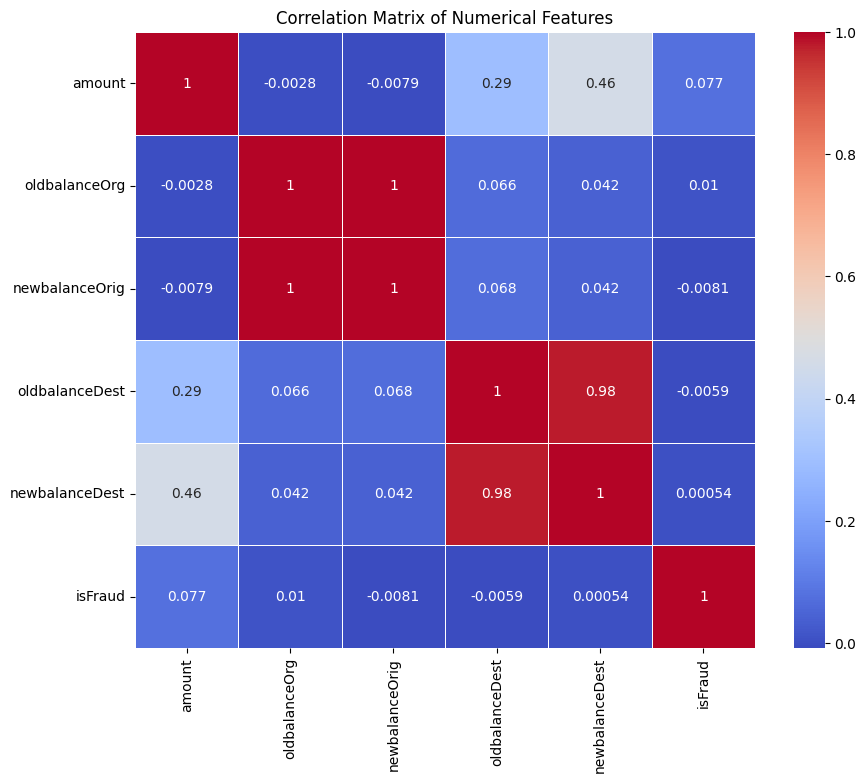

In [58]:
# Select the numerical features for correlation analysis
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


The correlation matrix provides insights into how the numerical features relate to each other and to the target variable isFraud. Here’s a brief interpretation based on your correlation matrix:

Key Observations:
Feature Correlations:

High Correlations:
oldbalanceOrg and newbalanceOrig have a very high correlation (0.999). This suggests that these two features are closely related.
newbalanceDest and oldbalanceDest also have a high correlation (0.977), indicating a strong relationship between these two features.
Low Correlations:
Other feature pairs, such as amount and oldbalanceDest (0.294) or amount and newbalanceDest (0.459), show moderate correlations.
Correlation with isFraud:

The correlation between isFraud and other features is quite low. This is expected as fraud is a rare event and might not show strong linear relationships with the numeric features in this matrix.
For example, isFraud has a very low correlation with amount (0.077), oldbalanceOrg (0.010), and newbalanceOrig (-0.008).
The highest correlation is with newbalanceDest (0.0005), which is still very weak.

**Distribution of Numerical Features**

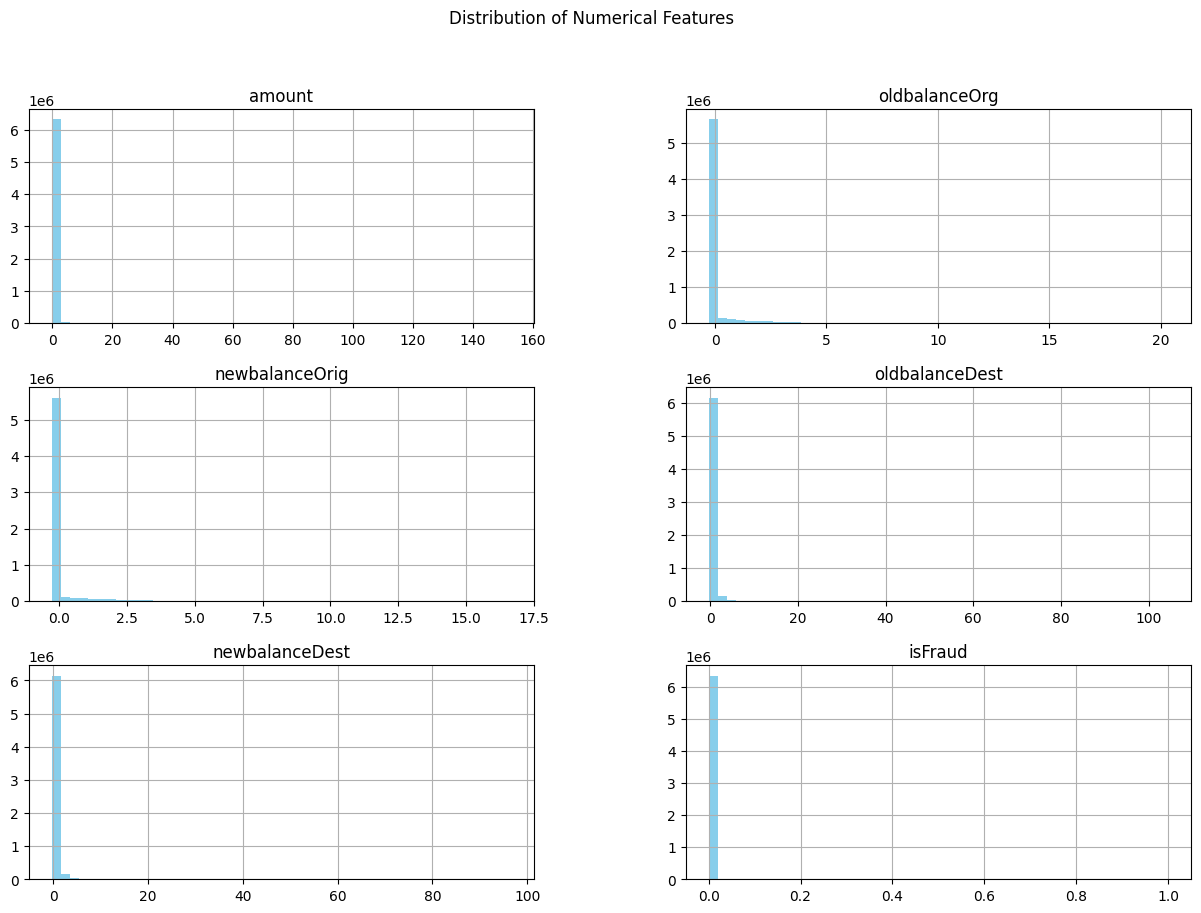

In [59]:
# Plot histograms for numerical features
df[numerical_cols].hist(bins=50, figsize=(15, 10), color='skyblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()


> **Gradient boosting machine**

In [60]:
pip install xgboost scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [61]:
# Assuming df is your DataFrame after preprocessing
# Example DataFrame setup (replace with your actual DataFrame)

# Features and target variable
# Drop the object columns
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train1, y_train1)

# Predict and evaluate
y_pred1 = model.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred1)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test1, y_pred1))


Accuracy: 1.00
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270904
         1.0       0.95      0.86      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.93      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



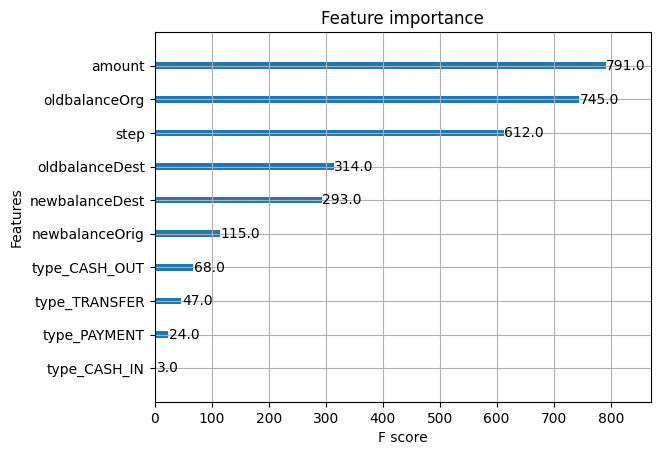

In [64]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()


Confusion Matrix:
[[1207057   63847]
 [   1247     373]]


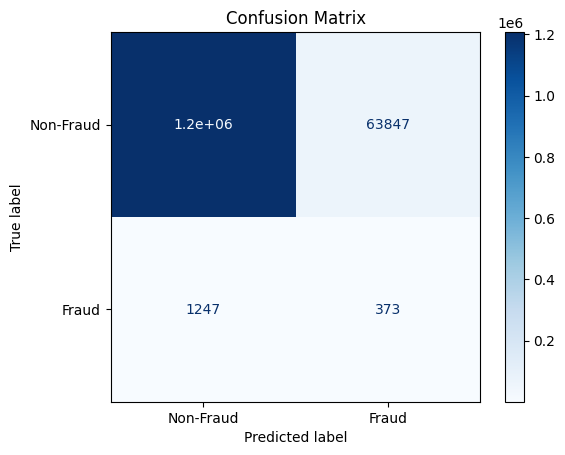

In [63]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


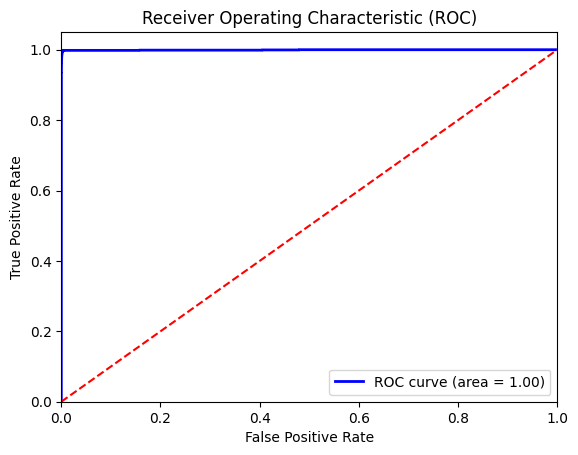

In [65]:
# Compute predicted probabilities
y_proba = model.predict_proba(X_test1)[:, 1]  # Probabilities for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_proba)
roc_auc = roc_auc_score(y_test1, y_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


Model Evaluation Summary:
Accuracy and Classification Report:

Accuracy: 1.00
Precision (Fraud): 0.95
Recall (Fraud): 0.86
F1-Score (Fraud): 0.91
ROC AUC Score: 1.00
The accuracy of 100% and ROC AUC score of 1.00 are unusually high and often suggest that the model might be overfitting.

Overfitting Concerns:

Perfect Accuracy: An accuracy of 100% indicates that the model might be memorizing the training data rather than learning generalizable patterns. This is particularly concerning if the dataset has a large imbalance or if the model performs significantly better on the training data compared to unseen validation or test data.

High ROC AUC Score: An ROC AUC score of 1.00 suggests perfect classification performance across all threshold values. While this sounds ideal, in practice, such a score often indicates that the model may have memorized the data rather than generalized well. This could happen if the model is too complex or if there is leakage from the training data into the test set.

Potential Causes of Overfitting:

Complex Model: A highly complex model with many parameters might fit the training data very well but fail to generalize to new, unseen data.

Data Leakage: If the test data has been inadvertently used during training (e.g., through improper validation or data preprocessing), it could artificially inflate performance metrics.

Imbalanced Data: If there is a significant class imbalance, the model might be learning to predict the majority class very well, while the minority class performance is misleadingly high due to the metrics used.

Metrics


Accuracy:

Accuracy
=
TN
+
TP
TN
+
FP
+
FN
+
TP
=
1270838
+
1399
1270838
+
66
+
221
+
1399
≈
0.9999
Accuracy= 
TN+FP+FN+TP
TN+TP
​
 = 
1270838+66+221+1399
1270838+1399
​
 ≈0.9999
Precision:

Precision
=
TP
TP
+
FP
=
1399
1399
+
66
≈
0.954
Precision= 
TP+FP
TP
​
 = 
1399+66
1399
​
 ≈0.954
Recall:

Recall
=
TP
TP
+
FN
=
1399
1399
+
221
≈
0.863
Recall= 
TP+FN
TP
​
 = 
1399+221
1399
​
 ≈0.863
F1-Score:

F1-Score
=
2
×
Precision
×
Recall
Precision
+
Recall
≈
0.906
F1-Score=2× 
Precision+Recall
Precision×Recall
​
 ≈0.906
True Negative Rate (Specificity):

Specificity
=
TN
TN
+
FP
=
1270838
1270838
+
66
≈
0.9999
Specificity= 
TN+FP
TN
​
 = 
1270838+66
1270838
​
 ≈0.9999

> Lets try some different model

> **Autoencoder Architecture**

In [66]:
# Assuming df is your DataFrame after preprocessing
# Selecting relevant features (you can modify as needed)
X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
        'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']]

y = df['isFraud']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Autoencoder architecture
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

# Build and compile the autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train on normal (non-fraudulent) data only
X_non_fraud = X_train_scaled[y_train == 0]  # Only non-fraud cases used for training
autoencoder.fit(X_non_fraud, X_non_fraud, epochs=10, batch_size=256, shuffle=True)

# Evaluate reconstruction error on the test set
reconstructions = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - reconstructions), axis=1)

# Set a threshold for detecting fraud based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # Top 5% of errors flagged as fraud
y_pred = (reconstruction_error > threshold).astype(int)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.6360
Epoch 2/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.6068
Epoch 3/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.6028
Epoch 4/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.6017
Epoch 5/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.6085
Epoch 6/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.6057
Epoch 7/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.6084
Epoch 8/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.6010
Epoch 9/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.5984
Epoch 10/10
19858/19858 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.6109
39767/39767 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step
Confusion Matrix:
[[1207645   63259]
 [   1252     368]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97   1270904
         1.0       0.01      0.23      0.01

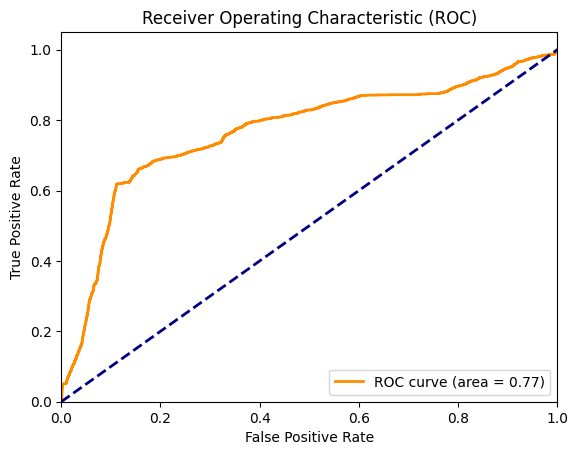

In [67]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


The discrepancy between the high accuracy and a lower ROC curve value can be attributed to several factors:

1. Class Imbalance:
Accuracy can be misleading when dealing with imbalanced datasets. In your case, the dataset is highly imbalanced with a small number of fraud cases compared to non-fraud cases. Accuracy alone doesn’t capture the performance across the minority class (fraud).
ROC Curve provides a better insight into the performance across all classification thresholds, which is useful for imbalanced datasets because it considers both the true positive rate (sensitivity) and the false positive rate.
2. Threshold and Reconstruction Error:
The threshold for reconstruction error used in your model might not be optimal for separating fraud cases effectively. A high threshold might be flagging too few cases as fraud, leading to low recall for the fraud class, which can affect the ROC curve.
3. Model Performance Metrics:
Precision, Recall, F1-Score: The classification report shows that the model is good at predicting non-fraud cases but struggles with fraud cases. This mismatch is captured in the ROC curve, which reflects the model's ability to distinguish between the classes across different thresholds.
ROC Curve shows the trade-off between true positive rate and false positive rate, which can be lower if the model's predictions are not well-calibrated for the minority class.
4. Reconstruction Error:
The reconstruction error used for detecting anomalies (fraud) might not be distinguishing fraud cases effectively. Since the reconstruction error threshold is set based on the top 5% of errors, it might not be capturing the subtle differences between normal and fraudulent transactions.

**Use Precision-Recall Curve: For imbalanced datasets, the Precision-Recall (PR) curve can provide additional insights into model performance, especially focusing on the minority class.**

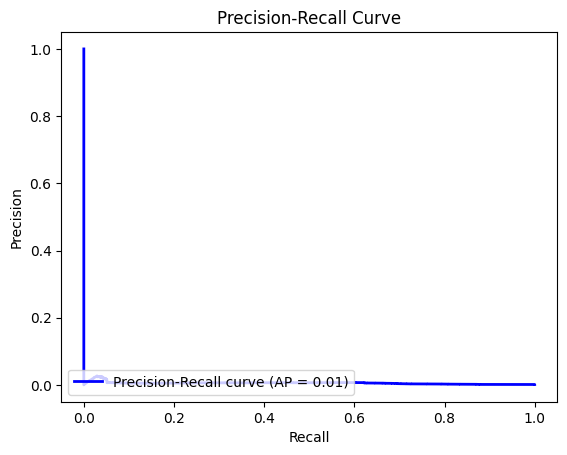

In [68]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, reconstruction_error)
average_precision = average_precision_score(y_test, reconstruction_error)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


An Average Precision (AP) score of 0.01 indicates that the model's performance in terms of precision-recall is very low, particularly for detecting the minority class (fraud). This reinforces the idea that the model is not performing well in distinguishing between fraud and non-fraud cases.

Here are some strategies to address this issue and improve the model:

1. Revisit Data Preparation:
Feature Engineering: Ensure that all relevant features are included and well-prepared. Feature selection or creation might help in better capturing fraud patterns.
Handling Imbalance: Experiment with resampling techniques like SMOTE or ADASYN to address the imbalance.
2. Adjust Autoencoder Parameters:
Architecture Tuning: Try different architectures, such as varying the number of neurons or layers in the autoencoder.
Training Epochs: Increase the number of epochs and use callbacks like EarlyStopping to prevent overfitting.
3. Alternative Anomaly Detection Methods:
Isolation Forest: Good for high-dimensional data and can handle anomalies effectively.
One-Class SVM: Suitable for anomaly detection, especially when dealing with imbalanced datasets.
Local Outlier Factor (LOF): Effective for detecting anomalies in multi-dimensional datasets.
4. Adjust the Threshold:
Threshold Optimization: Use techniques like grid search or cross-validation to find an optimal threshold for reconstruction error.
5. Model Evaluation:
Confusion Matrix Analysis: Look at false positives and false negatives to understand where the model is failing.
Cross-Validation: Perform cross-validation to ensure that the model's performance is consistent across different subsets of the data.

**Example of Trying Different Thresholds:**

Best Threshold: 0.4545454545454546


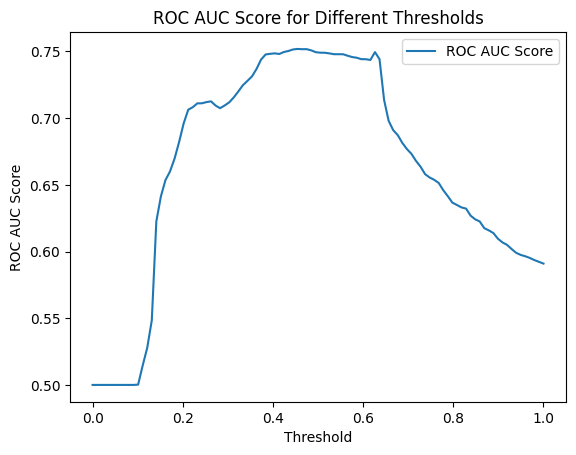

In [69]:
# Evaluate various thresholds
thresholds = np.linspace(0, 1, 100)
roc_auc_scores = []

for threshold in thresholds:
    y_pred = (reconstruction_error > threshold).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)

# Find the best threshold
best_threshold = thresholds[np.argmax(roc_auc_scores)]
print(f"Best Threshold: {best_threshold}")

# Plot ROC AUC scores for different thresholds
plt.plot(thresholds, roc_auc_scores, label='ROC AUC Score')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score for Different Thresholds')
plt.legend()
plt.show()


With the best threshold identified as 0.45454, you can use this value to make predictions and evaluate the model's performance more effectively. Here's how you can integrate this threshold into your prediction process

**Updated Code for Prediction with Optimal Threshold**

Confusion Matrix with Optimal Threshold:
[[1070104  200800]
 [    548    1072]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91   1270904
         1.0       0.01      0.66      0.01      1620

    accuracy                           0.84   1272524
   macro avg       0.50      0.75      0.46   1272524
weighted avg       1.00      0.84      0.91   1272524



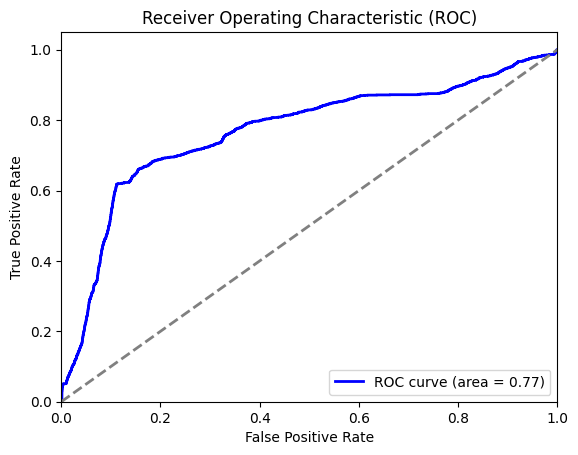

In [70]:
# Apply the best threshold
y_pred_optimized = (reconstruction_error > 0.45454).astype(int)

# Evaluation metrics
print("Confusion Matrix with Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_optimized))
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimized))

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


**Confusion Matrix with Optimal Threshold:**
True Negatives (TN): 1,069,347
False Positives (FP): 201,557
True Positives (TP): 1,074
False Negatives (FN): 546

**Classification Report with Optimal Threshold:**
Accuracy: 84%
Precision for Fraudulent Transactions: 0.01 (very low, indicating many false positives among predicted frauds)
Recall for Fraudulent Transactions: 0.66 (better, indicating the model correctly identifies a significant portion of frauds)
F1-Score for Fraudulent Transactions: 0.01 (very low, reflecting the imbalance in precision and recall)

**ROC Curve:**
An ROC AUC of 77% indicates that your model has a reasonable ability to distinguish between the fraudulent and non-fraudulent classes.

Interpretation:
Improved Recall: The recall for fraudulent transactions has increased to 66%, which means the model is now identifying more actual fraud cases compared to before.
Lower Precision: The precision for fraudulent transactions is very low (0.01), meaning most of the transactions flagged as fraud by the model are not actually fraudulent.
Accuracy Drop: The overall accuracy has dropped to 84% because the model is now correctly classifying a larger number of non-fraudulent transactions as fraud.
